# PWV effects on SN Magnitude

This notebook demonstrates the effects of PWV absorption on the apparent magnitude of SNe.


In [1]:
import sys
sys.path.insert(0, '../')

from pathlib import Path

import numpy as np
import sncosmo
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from sn_analysis import modeling, sn_magnitudes, reference, plotting
from sn_analysis.utils import register_decam_filters


In [2]:
fig_dir = Path('.') / 'figs'
fig_dir.mkdir(exist_ok=True, parents=True)
register_decam_filters(force=True)


In [3]:
source = 'salt2-extended'
pwv_vals = np.arange(0, 10)
z_vals = np.arange(.01, 1.1, .05)
bands = 'decam_r', 'decam_i', 'decam_z', 'decam_y'


## Spectral Template

The effect of PWV absorption is fundementally dependent on the interplay between the SED of the effected object and the PWV transmission function. For this work we consider an extend version of the Salt2 spectral template. We visualize the template as a reference. For easier visualization, the figure below includes dialation effects but does not include the change in flux density due to distance.


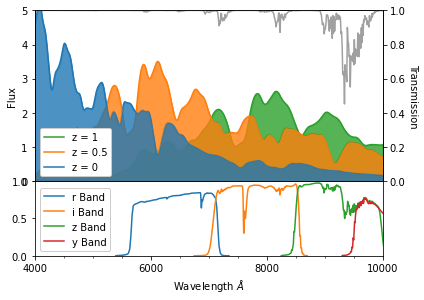

In [4]:
_ = plotting.plot_salt2_template(np.arange(4000, 10000), [0, .5, 1], pwv=4)
plt.savefig(fig_dir / 'spectral_template.pdf', bbox_inches='tight')


## Apparent magnitude

We start by considering the direct impact of PWV absorbtion on simulated SN Ia magnitudes. Apparent magnitudes are simulated for multiple bands, redshifts, and PWV concentrations. 


In [5]:
tabulated_mag = sn_magnitudes.tabulate_mag(source, pwv_vals, z_vals, bands)


Tabulating Mag: 100%|██████████| 880/880 [01:44<00:00,  8.38it/s]


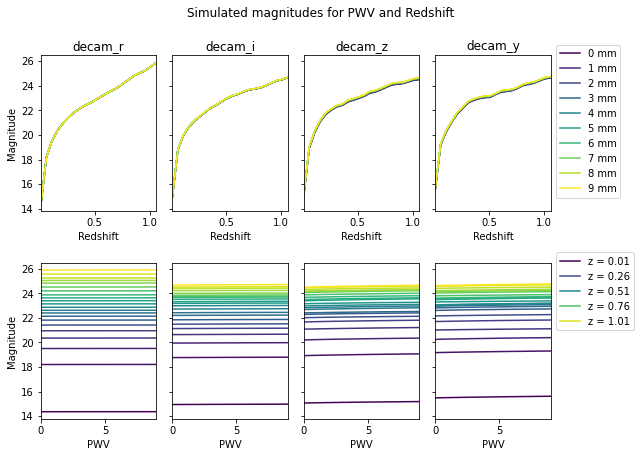

In [6]:
fig, axes = plotting.plot_magnitude(tabulated_mag, pwv_vals, z_vals)
_ = fig.suptitle('Simulated magnitudes for PWV and Redshift', y=1.05)
plt.savefig(fig_dir / 'tabulated_magnitudes.pdf', bbox_inches='tight')


To better understand the impact of PWV, we estimate the change in apparent magnitude due to PWV. Although we could measure this change relative to PWV=0, a more physically motivated approach is to use a fiducial atmosphere with a non-zero PWV component:

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z)$$

We also determine the slope in the apparent magnitude as an estimate for how sensitive our simulated observations are to PWV fluxtuations:

$$\frac{\Delta m}{\Delta \text{PWV}}(z) = \frac{m(\text{PWV}_2, z) - m(\text{PWV}_1, z)}{\text{PWV}_2 - \text{PWV}_1}$$

Here PWV$_1$ and PWV$_2$ are chosen to be equidistant to PWV$_f$. We take note of the chosen PWV reference values in the following cell:


In [7]:
reference_pwv_config = reference.get_config_pwv_vals()
print(reference_pwv_config)


{'reference_pwv': 4.0, 'slope_start': 2.0, 'slope_end': 6.0}


We tabulate values for $\Delta m$ and $\frac{\Delta m}{\Delta \text{PWV}}(z)$. 

In [8]:
tabulated_fiducial_mag = sn_magnitudes.tabulate_fiducial_mag(
        source, z_vals, bands, reference_pwv_config)

tabulated_delta_mag, tabulated_slope = sn_magnitudes.calc_delta_mag(
    tabulated_mag, tabulated_fiducial_mag, reference_pwv_config)


Tabulating Mag: 100%|██████████| 264/264 [00:31<00:00,  8.31it/s]


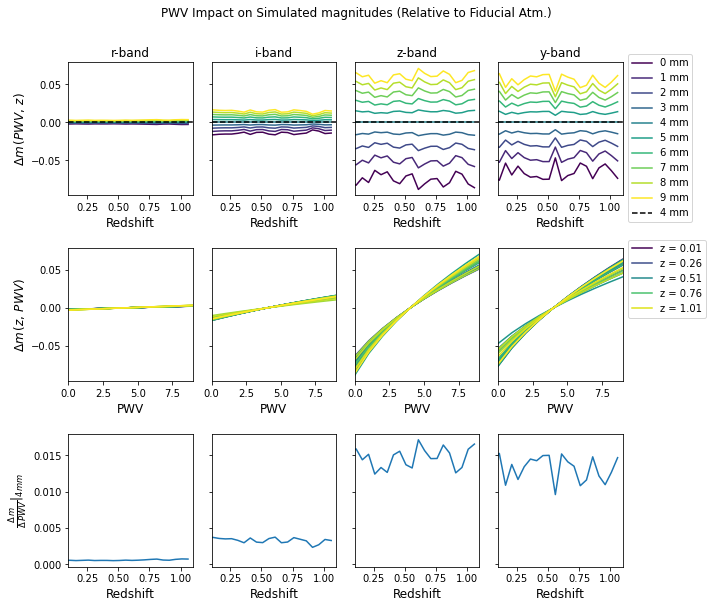

In [9]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag, 
    tabulated_slope, 
    bands)

_ = fig.suptitle('PWV Impact on Simulated magnitudes (Relative to Fiducial Atm.)', y=1.05)
plt.savefig(fig_dir / 'tabulated_pwv_effects.pdf', bbox_inches='tight')


---

**Sanity Check:** We expect to see the following trends in the above plot:
- The bluer bands should have minimal PWV impact. 
- The size of $\Delta$m should be largest for the redder bands. 
- The slope in $\Delta$m should be almost zero in the bleuer bands.
- $\Delta$m should be zero for the fiducial PWV value.
- The general shape of the $\Delta m$ vs PWV curves should change as a function of different features passing through each band. This means the shape of the curves should be different in each band.

---

## $\Delta m$ With Fitting

Instead of tabulating the simulating magnitude, we can instead consider the change in magnitude by simulating light-curves with PWV effects and then fitting a model without a PWV component. For simplicity we use a densly sampled, uniform cadence.

In [10]:
cadence = modeling.create_observations_table()
cadence


time,band,gain,skynoise,zp,zpsys
int64,str7,int64,int64,int64,str10
-20,decam_g,100,0,25,ab
-20,decam_g,100,0,25,ab
-20,decam_g,100,0,25,ab
-20,decam_g,100,0,25,ab
-20,decam_g,100,0,25,ab
-19,decam_r,100,0,25,ab
-19,decam_r,100,0,25,ab
-19,decam_r,100,0,25,ab
-19,decam_r,100,0,25,ab


Here is an example light-curve

In [11]:
next(modeling.iter_lcs(cadence, source, pwv_vals, z_vals))

Light-Curves:   0%|          | 0/220 [00:00<?, ?it/s]


time,band,flux,fluxerr,zp,zpsys
int64,str7,float64,float64,float64,str10
-20,decam_g,6.1632110373637286,0.24958139265288432,25.0,ab
-20,decam_g,6.444226986408403,0.24958139265288432,25.0,ab
-20,decam_g,6.130985045456724,0.24958139265288432,25.0,ab
-20,decam_g,5.948430288879795,0.24958139265288432,25.0,ab
-20,decam_g,5.968709709161001,0.24958139265288432,25.0,ab
-19,decam_r,50.03792333809856,0.7114447061009094,25.0,ab
-19,decam_r,50.58837691351158,0.7114447061009094,25.0,ab
-19,decam_r,50.614313594908836,0.7114447061009094,25.0,ab
-19,decam_r,51.82465450819752,0.7114447061009094,25.0,ab


In [12]:
# Iterator over simulated light-curves
light_curves = modeling.iter_lcs(cadence, source, pwv_vals, z_vals)

# Fit light curves
vparams = ['x0', 'x1', 'c']
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
        source, light_curves, vparams, pwv_vals, z_vals, bands)

# Get fiducial mag
fitted_fiducial_mag, fitted_fiducial_params = sn_magnitudes.fit_fiducial_mag(
        source, cadence, vparams, z_vals, bands, reference_pwv_config)


Light-Curves: 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


Here we visualize the fitted, uncorrected (i.e. without any stretch / color corrections) magnitudes.

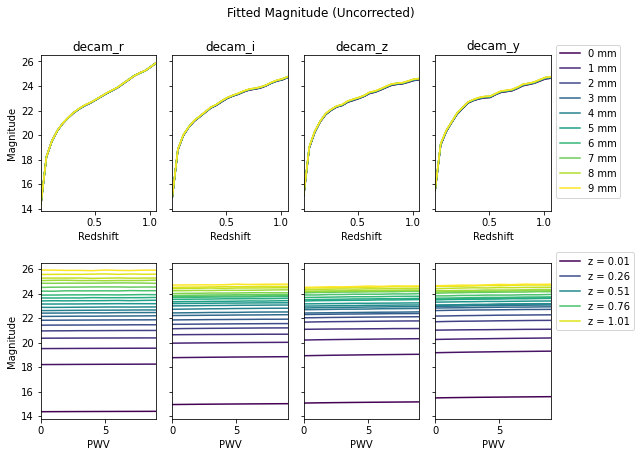

In [13]:
fig, axes = plotting.plot_magnitude(fitted_mag, pwv_vals, z_vals)
_ = fig.suptitle('Fitted Magnitude (Uncorrected)', y=1.05)
plt.savefig(fig_dir / 'fitted_magnitudes.pdf', bbox_inches='tight')


---

**Sanity Check:** The fitted light-curves are constructed to have a dense, uniform sampling. As a result, the fitted magnitude should look extremly similar to the tabulated magnitudes from earlier in the notebook.

---

We expect to see minimal differences between the tabulated, and fitted magnitudes in each band. However, we do expect to variation in the fitted stretch and color.

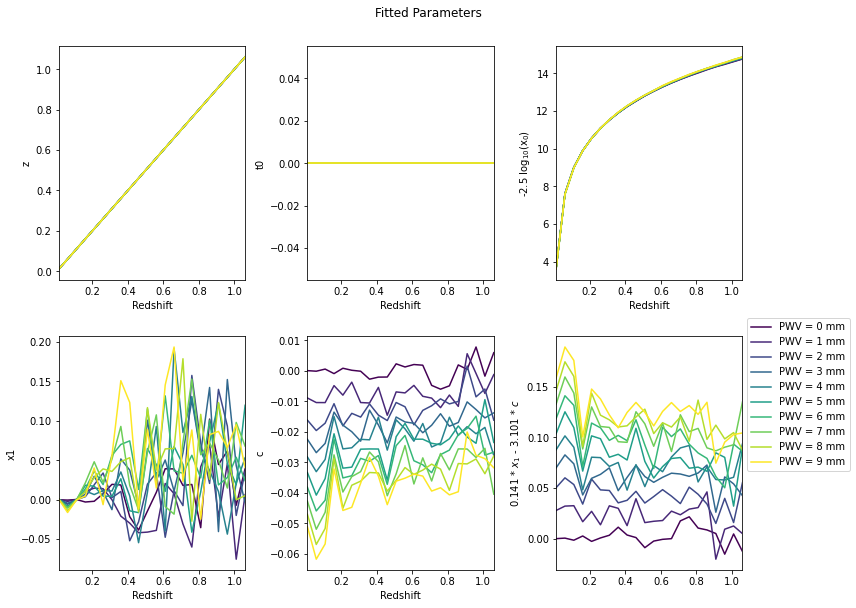

In [14]:
fig, axes = plotting.plot_fitted_params(fitted_params, pwv_vals, z_vals, bands)
_ = fig.suptitle('Fitted Parameters', y=1.05)
plt.savefig(fig_dir / 'fitted_parameters.pdf', bbox_inches='tight')


We look at the impact of PWV on the fitted magnitude.

In [15]:
corrected_delta_mag, corrected_slope = sn_magnitudes.calc_delta_mag(
    fitted_mag, fitted_fiducial_mag, reference_pwv_config)


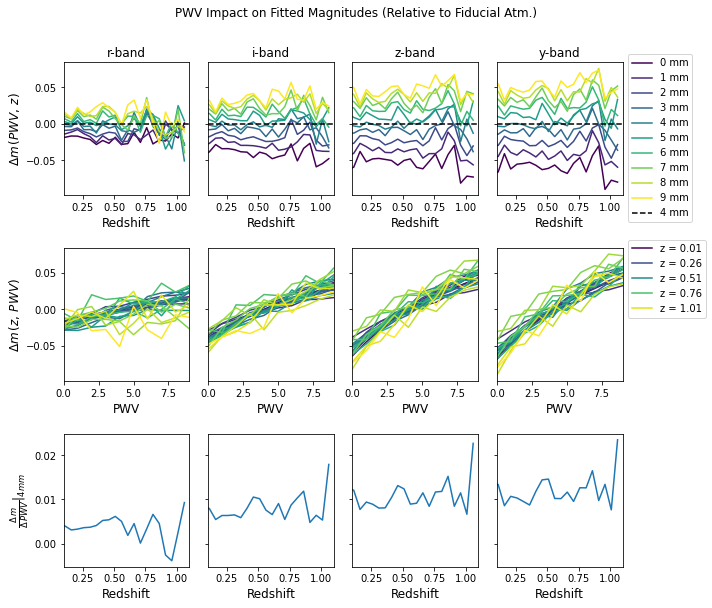

In [16]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag, 
    corrected_slope, 
    bands)

_ = fig.suptitle('PWV Impact on Fitted Magnitudes (Relative to Fiducial Atm.)', y=1.05)
plt.savefig(fig_dir / 'fitted_pwv_effects.pdf', bbox_inches='tight')


Next we add in the alpha and beta parameters from the fit.

In [17]:
# Determine corrected magnitude from fits
corrected_mag = {}
corrected_fiducial_mag = {}
for band in bands:
    corrected_mag[band] = sn_magnitudes.correct_mag(
        source, fitted_mag[band], fitted_params[band])

    # Get fiducial mag (calibrated)
    corrected_fiducial_mag[band] = sn_magnitudes.correct_mag(
        source, fitted_fiducial_mag[band], fitted_fiducial_params[band])


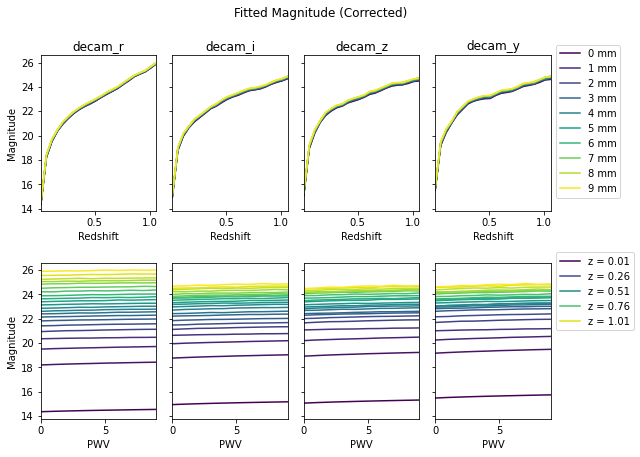

In [18]:
fig, axes = plotting.plot_magnitude(corrected_mag, pwv_vals, z_vals)
_ = fig.suptitle('Fitted Magnitude (Corrected)', y=1.05)
plt.savefig(fig_dir / 'corr_fitted_magnitudes.pdf', bbox_inches='tight')


In [19]:
corrected_delta_mag, corrected_slope = sn_magnitudes.calc_delta_mag(
        corrected_mag, corrected_fiducial_mag, reference_pwv_config)


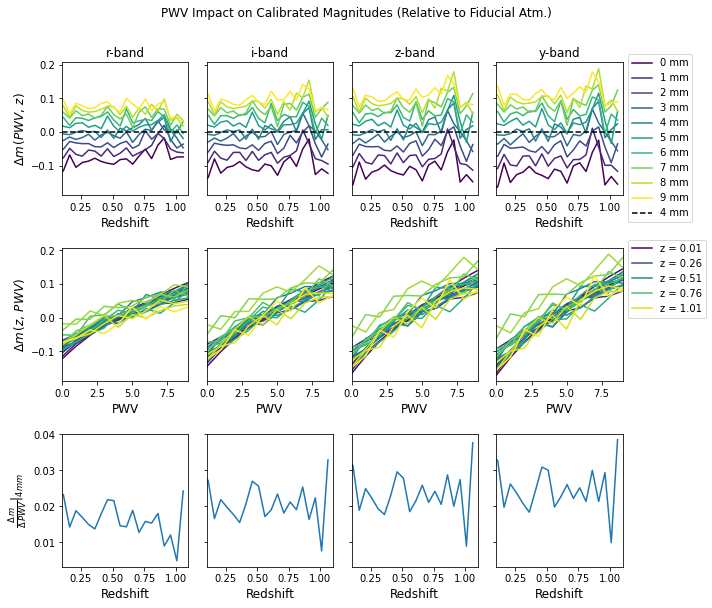

In [20]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag, 
    corrected_slope, 
    bands)

_ = fig.suptitle('PWV Impact on Calibrated Magnitudes (Relative to Fiducial Atm.)', y=1.05)
plt.savefig(fig_dir / 'corr_pwv_effects.pdf', bbox_inches='tight')


---

**Sanity Check:** Unlike some of the previous plots we have made, we expect the overall shape of the the $\Delta m$ vs $z$ curves to be similar across bands. Since we are considereing fitted magnitudes in the above plot, the presence of PWV impacts the fitted model parameters, and then the model enforces cross-band uniformity when we evaluate the synthetic photometry.

---

# Relative to a Reference Star

In practice flux values are calibrated relative to a reference star. To understand how PWV effects SNe fluxes during this process, we normalize the SNe and reference star flux to their respective fluxes through the fiducial atmosphere and take the difference (Normalized SNe - normalized reference star).

Note that the value of $\Delta m$ is we calculated before is equivilent to the apparent SN magnitude normalized to the flux through the fiducial atmosphere.

$$\Delta m = m(\text{PWV}, z) - m(\text{PWV}_f, z) = -2.5 log\left(\frac{f(\text{PWV}, z)}{f(\text{PWV}_f, z)}\right)$$

In [21]:
# The y band values are not available for the reference star
# we drop them here

_tabulated_delta_mag = tabulated_delta_mag.copy()
_tabulated_delta_mag.pop('decam_y')

_tabulated_slope = tabulated_slope.copy()
_tabulated_slope.pop('decam_y')

# Subtraction is made using a G2 star
tabulated_delta_mag_g2 = reference.subtract_ref_star_dict(_tabulated_delta_mag, pwv_vals)
tabulated_slope_g2 = reference.subtract_ref_star_slope(_tabulated_slope, reference_pwv_config)


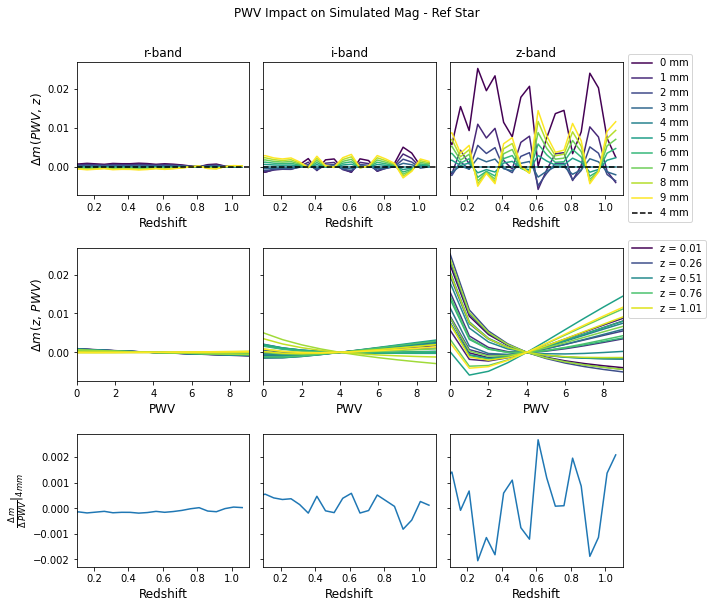

In [22]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    tabulated_delta_mag_g2, 
    tabulated_slope_g2, 
    bands[:-1])

_ = fig.suptitle('PWV Impact on Simulated Mag - Ref Star', y=1.05)


In [23]:
_corrected_delta_mag = corrected_delta_mag.copy()
_corrected_delta_mag.pop('decam_y')

_corrected_slope = corrected_slope.copy()
_corrected_slope.pop('decam_y')

corrected_delta_mag_g2 = reference.subtract_ref_star_dict(_corrected_delta_mag, pwv_vals)
corrected_slope_g2 = reference.subtract_ref_star_slope(_corrected_slope, reference_pwv_config)


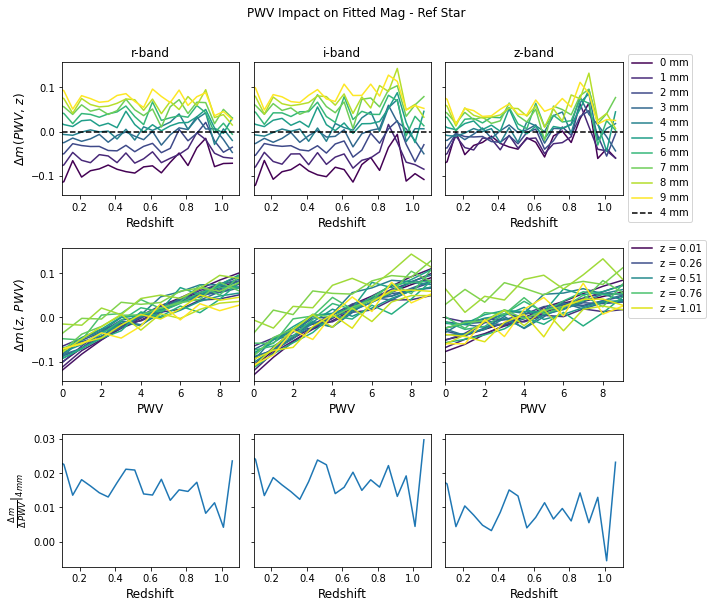

In [24]:
fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag_g2,
    corrected_slope_g2,
    bands)

_ = fig.suptitle('PWV Impact on Fitted Mag - Ref Star', y=1.05)


### Calibrating to a Reference Star BEFORE Fitting

Note that in the above plot we have subtracted off the reference star **after** fitting the light-curve. In principle we should have subtracted of the reference before executing the fit, as follows:


In [25]:
def iter_light_curve_iter_with_ref(source, vparams, pwv_arr, z_arr, reference_type='G2'):
    
    bands = ('decam_r', 'decam_i', 'decam_z')
    
    # Unfortunatly we can't specify a redshift dependent zero point
    # in the sncosmo observations table so we build an iterater over some 
    # lightcurves and recalibrate to a new zeropoint retroactively
    initial_zeropoint = 25
    observations = modeling.create_observations_table(bands=bands, zp=initial_zeropoint)
    light_curves = modeling.iter_lcs(observations, source, pwv_arr, z_arr)
    
    # Determine what the reference mag should be
    print('Fitting fiducial mag', flush=True)
    fiducial_mag_dict, _ = sn_magnitudes.fit_fiducial_mag(
        source, observations, vparams, z_arr, bands, reference_pwv_config)
    
    print('Fitting light-curves at given PWV and redshift', flush=True)
    for lc in light_curves:
        z = lc.meta['z']
        pwv = lc.meta['pwv']
        
        # fiducial_magnitudes includes arrays for the slope start point, 
        # ficudial atm, and slope end point        
        for band, (_, fiducial_mag, _ ) in fiducial_mag_dict.items():

            # Index ficudial magnitude array to get ZP for the appropriate redshift
            zp_for_z = fiducial_mag[np.where(z_arr == z)[0]]
            
            # Change the zeropoint for the current band to be relative to the
            # fiducial atmosphere
            indices = lc['band'] == band
            lc['flux'][indices] *= 10 ** ((zp_for_z - initial_zeropoint) / 2.5)
            lc['fluxerr'][indices] *= 10 ** ((zp_for_z - initial_zeropoint) / 2.5)
            lc['zp'][indices] = zp_for_z
        
        # Subtract off reference star
        yield reference.subtract_ref_from_lc(lc, pwv, reference_type)
    

In [26]:
vparams = ['x0', 'x1', 'c']
light_curves_with_ref = iter_light_curve_iter_with_ref(source, vparams, pwv_vals, z_vals)
fitted_mag_with_ref, fitted_params_with_ref = sn_magnitudes.fit_mag(
        source, light_curves_with_ref, vparams, pwv_vals, z_vals, bands)


Fitting fiducial mag


Light-Curves: 100%|██████████| 66/66 [00:39<00:00,  1.69it/s]

Fitting light-curves at given PWV and redshift



Light-Curves: 100%|██████████| 220/220 [02:09<00:00,  1.71it/s]


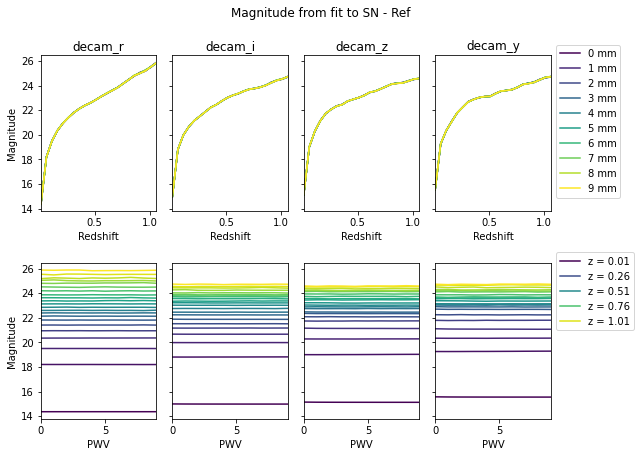

In [27]:
fig, axes = plotting.plot_magnitude(fitted_mag_with_ref, pwv_vals, z_vals)
_ = fig.suptitle('Magnitude from fit to SN - Ref', y=1.05)


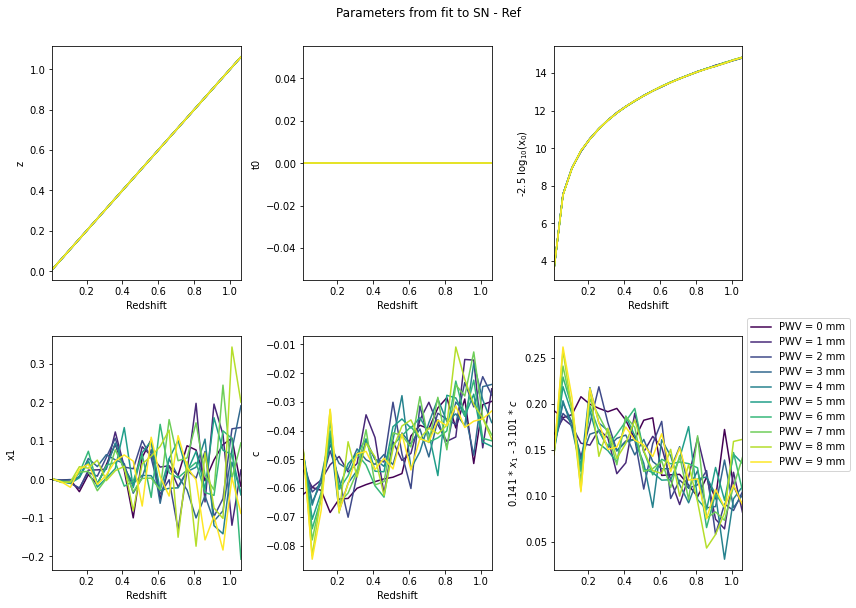

In [28]:
fig, axes = plotting.plot_fitted_params(fitted_params_with_ref, pwv_vals, z_vals, bands)
_ = fig.suptitle('Parameters from fit to SN - Ref', y=1.05)


In [29]:
# Determine corrected magnitude from fits
corrected_mag_with_ref = {}
for band in bands:
    corrected_mag_with_ref[band] = sn_magnitudes.correct_mag(
        source, fitted_mag_with_ref[band], fitted_params_with_ref[band])


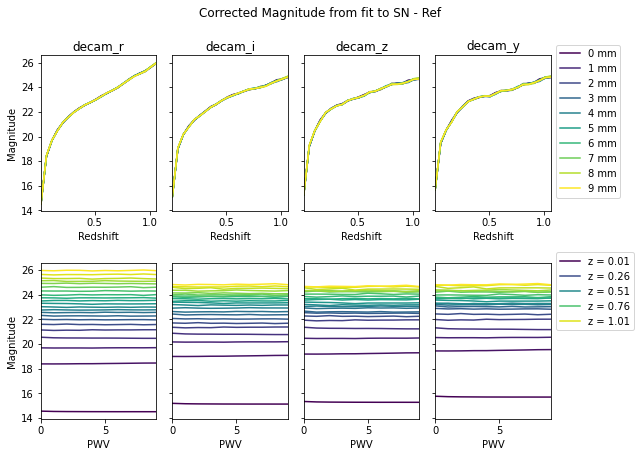

In [30]:
fig, axes = plotting.plot_magnitude(corrected_mag_with_ref, pwv_vals, z_vals)
_ = fig.suptitle('Corrected Magnitude from fit to SN - Ref', y=1.05)


In [31]:
_pwv_list = list(pwv_vals)
reference_idx = _pwv_list.index(reference_pwv_config['reference_pwv'])
slope_start_idx = _pwv_list.index(reference_pwv_config['slope_start'])
slope_end_idx = _pwv_list.index(reference_pwv_config['slope_end'])

corrected_fiducial_mag_with_ref = dict()
for band in bands:
    _mag_arr = corrected_mag_with_ref[band]
    _ref_mag = _mag_arr[reference_idx]
    _start_mag = _mag_arr[slope_start_idx]
    _end_mag = _mag_arr[slope_end_idx]
    
    corrected_fiducial_mag_with_ref[band] = [_start_mag, _ref_mag, _end_mag]  
    

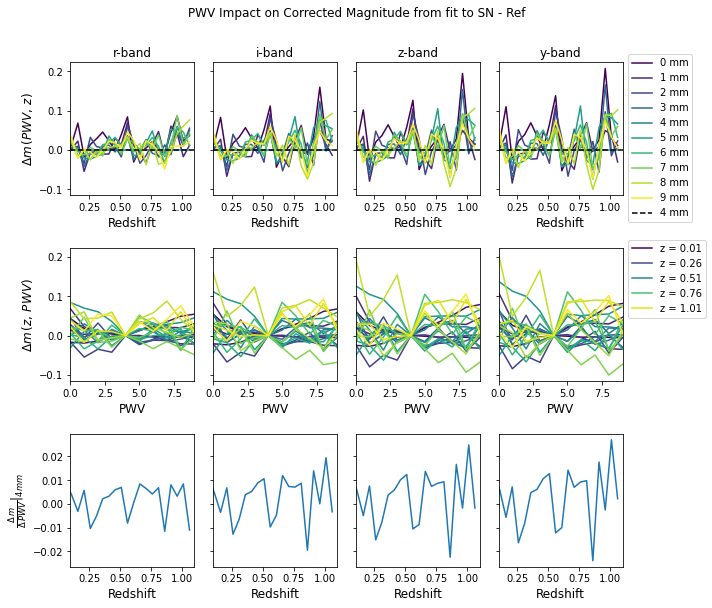

In [32]:
corrected_delta_mag_with_ref, corrected_slope_with_ref = sn_magnitudes.calc_delta_mag(
        corrected_mag_with_ref, corrected_fiducial_mag_with_ref, reference_pwv_config)

fig, axes = plotting.plot_pwv_mag_effects(
    pwv_vals, 
    z_vals, 
    corrected_delta_mag_with_ref, 
    corrected_slope_with_ref, 
    bands)

fig.suptitle('PWV Impact on Corrected Magnitude from fit to SN - Ref', y=1.05)
plt.savefig(fig_dir / 'corr_pwv_effects_with_ref_star.pdf', bbox_inches='tight')


## Delta $\mu$

Here we consider the impact of PWV on $\mu$ using fits to SNe flux after calibration to the reference star.

In [91]:
# We use cosmological parameters from Betoule 14
betoule_cosmo = FlatLambdaCDM(H0=sn_magnitudes.H0, Om0=sn_magnitudes.omega_m)
betoule_cosmo


FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.295, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)

In [102]:
reload(sn_magnitudes)

<module 'sn_analysis.sn_magnitudes' from '../sn_analysis/sn_magnitudes.py'>

In [103]:
# The params are band independent
params_for_mu = fitted_params_with_ref['decam_r']
fitted_mu = sn_magnitudes.calc_mu_for_params(source, params_for_mu)

# Parse the fitted parameters for easier plotting
model = sncosmo.Model('salt2-extended')
params_dict = {
    param: params_for_mu[..., i] for
    i, param in enumerate(model.param_names)
}

correction_factor = sn_magnitudes.alpha * params_dict['x1'] - sn_magnitudes.beta * params_dict['c']
corrected_fitted_mu = fitted_mu + correction_factor


In [104]:
def plot_mu(mu, cosmo, pwv_arr, z_arr, xval='redshift'):
    
    cosmo_mu = cosmo.distmod(z_arr).value
    delta_mu = mu - cosmo_mu
    corrected_delta_mu = delta_mu - cosmo_mu

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    mu_ax, delta_mu_ax, relative_mu_ax = axes

    plotting._multi_line_plot(z_arr, mu, pwv_arr, mu_ax)
    mu_ax.plot(z_arr, cosmo_mu, linestyle=':', color='k', label='Betoule 14')
    mu_ax.legend(framealpha=1)

    plotting._multi_line_plot(z_arr, delta_mu, pwv_arr, delta_mu_ax)
    delta_mu_ax.axhline(0, linestyle=':', color='k', label='Betoule 14')
    delta_mu_ax.legend(framealpha=1)

    plotting._multi_line_plot(z_arr, mu - mu[4], pwv_arr, relative_mu_ax, label='{:g} mm')
    relative_mu_ax.axhline(0, color='k', label=f'PWV={pwv_arr[4]}')
    relative_mu_ax.legend(framealpha=1, bbox_to_anchor=(1, 1.1))

    mu_ax.set_ylabel(r'$\mu$', fontsize=12)
    delta_mu_ax.set_ylabel(r'$\mu - \mu_{cosmo}$', fontsize=12)
    relative_mu_ax.set_ylabel(r'$\mu - \mu_{pwv_f}$', fontsize=12)
    for ax in axes:
        ax.set_xlabel('Redshift', fontsize=12)

    plt.tight_layout()


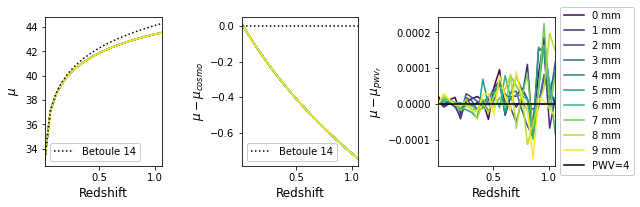

In [105]:
plot_mu(fitted_mu, betoule_cosmo, pwv_vals, z_vals)


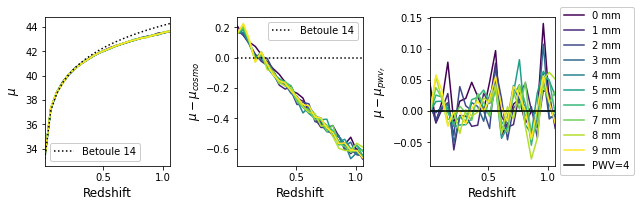

In [106]:
plot_mu(corrected_fitted_mu, betoule_cosmo, pwv_vals, z_vals)
plt.savefig(fig_dir / 'mu_pwv_effects.pdf', bbox_inches='tight')
